# Sentence Transformer

In [1]:
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## GPU

In [2]:
!nvidia-smi

Sun Aug 27 22:59:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   44C    P8              12W / 151W |   1787MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Path

## Generate dataset and batch

In [4]:
class PromptDataset(Dataset):

    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def deserialize_array(self, binary_string, dtype, shape):
        return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

    def __getitem__(self, index):
        data = self.dataset[index]
        # retrieve values
        student_id = data['student_id']
        prompt_id = data['prompt_id']
        prompt_question = torch.tensor(self.deserialize_array(data['prompt_question'], np.float32, (768,))).to(self.device)
        prompt_text = torch.tensor(self.deserialize_array(data['prompt_text'], np.float32, (768,))).to(self.device)
        text = torch.tensor(self.deserialize_array(data['text'], np.float32, (768,))).to(self.device)
        content = torch.tensor(data['content']).to(self.device)
        wording = torch.tensor(data['wording']).to(self.device)
        normalized_content = torch.tensor(data['normalized_content']).to(self.device)
        normalized_wording = torch.tensor(data['normalized_wording']).to(self.device)
        
        return {
            'student_id': student_id,
            'prompt_id': prompt_id,
            'prompt_question': prompt_question,
            'prompt_text': prompt_text,
            'text': text,
            'content': content,
            'wording': wording,
            'normalized_content': normalized_content,
            'normalized_wording': normalized_wording,
        }

    def __len__(self) -> int :
        return self.dataset.num_rows

In [5]:
class DataLoaderFactory():

    def __init__(self, path:str = './data/hugging_face', batch_size = 12, device = 'cpu'):
        self.batch_size = batch_size
        self.dataset = load_from_disk(path, keep_in_memory=True)
        self.device = device

        print("1. Loading dataset: ...", end="")
        dataset = load_from_disk(path, keep_in_memory=True)
        print("\r1. Loading dataset: done ✔️")

        print("2. Split datasets: ...", end="")
        train_validation_splits = self.dataset['train'].train_test_split(test_size=0.2)
        print("\r2. Preprocess datasets: done ✔️")

        print("3. Split datasets: ...", end="")
        self.train_data = PromptDataset(train_validation_splits['train'], self.device)
        self.val_data = PromptDataset(train_validation_splits['test'], self.device)
        print("\r3. Split datasets: done ✔️")

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
    
    
    def __len__(self) -> int :
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        else:
            dataloader = self.dataloader_val

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v for k, v in batch.items()}
            yield batch_on_device

### Load the dataset

In [6]:
dataset = DataLoaderFactory(device=device)
len(dataset)

1. Loading dataset: done ✔️
2. Preprocess datasets: done ✔️
3. Split datasets: done ✔️
Number of data by datasets splits
Train		: 5732	-> 477.6666666666667
Validation	: 1433		-> 119.41666666666667
Total		: 7165


7165

### Testing the dataset

In [7]:
batch = dataset.get_batch('train')
nb = next(batch)

In [8]:
print(f"{'student_id:':<25}{len(nb['student_id'])}")
print(f"{'prompt_id:':<25}{len(nb['prompt_id'])}")
print(f"{'prompt_question:':<25}{nb['prompt_question'].shape}")
print(f"{'prompt_text:':<25}{nb['prompt_text'].shape}")
print(f"{'text:':<25}{nb['text'].shape}")
print(f"{'content:':<25}{nb['content'].shape}")
print(f"{'wording:':<25}{nb['wording'].shape}")
print(f"{'normalized_content:':<25}{nb['normalized_content'].shape}")
print(f"{'normalized_wording:':<25}{nb['normalized_wording'].shape}")

student_id:              12
prompt_id:               12
prompt_question:         torch.Size([12, 768])
prompt_text:             torch.Size([12, 768])
text:                    torch.Size([12, 768])
content:                 torch.Size([12])
wording:                 torch.Size([12])
normalized_content:      torch.Size([12])
normalized_wording:      torch.Size([12])


## Training model

1. **Input Layer:** Accept the embeddings of the question, text, and answer. This would result in three separate input layers, each of dimension `[batch_size, embedding_size]`.
2. **Concatenate Layer:** Concatenate the embeddings along the feature axis. This results in `[batch_size, 3 * embedding_size]` dimensions.
3. **Dense Layers:** Add a couple of Dense layers with suitable dropout layers in between for regularization. For instance:
    - Dense layer with `1024` units, `ReLU` activation.
    - Dropout layer with rate `0.5`.
    - Dense layer with `512` units, ReLU activation.
    - Another Dropout layer with rate `0.5`.
4. **Output Layer:** Single Dense layer with `2` units (since you want two values between -1 and 1) and a `tanh` activation function.
5. **Loss Function:** If the output of your model is a vector with two values between -1 and 1, then you're essentially dealing with multi-output regression. You can use `Mean Squared Error` or `Mean Absolute Error`, but it'll be applied to each output.
6. **Optimizer:** Remains the same; options include `Adam`, `RMSprop`, and `SGD`.

### Define the Model

In [9]:
# Define the Model
class QA_Score_Model(nn.Module):
    def __init__(self, input_dim=2304, dropout_rate=0.5):
        super(QA_Score_Model, self).__init__()

        # Dense Layers
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)  # Output 2 values for each instance

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.training:
            x = self.dropout(x)
        x = F.relu(self.fc2(x))
        if self.training:
            x = self.dropout(x)
        x = torch.tanh(self.fc3(x))  # tanh to get outputs in range [-1, 1]
        return x

### Hyperparameters

In [10]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 12
EPOCHS = 10

### Create an instance of the model, loss function and the optimizer

In [11]:
# Create an instance of the model, loss function and the optimizer
model = QA_Score_Model()
model = model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### MCRMSE loss

In [12]:
def MCRMSE(targets, predictions):
    """
    Compute the Mean Columnwise Root Mean Squared Error.
    
    Parameters:
    - targets: Actual target values
    - predictions: Model's predictions
    
    Returns:
    - Mean Columnwise RMSE
    """
    # Compute squared error
    mse = torch.mean((targets - predictions) ** 2, dim=0)
    
    # Take square root of each column's MSE
    rmse = torch.sqrt(mse)
    
    # Compute mean of RMSE across all columns
    mcrmse = torch.mean(rmse)
    
    return mcrmse

### Training loop

In [13]:
def training_loop(model, dataset, epoch):
    model = model.train()
    
    total_train_loss = 0.0
    total_train_mcrmse = 0.0
    
    batchs = dataset.get_batch('train')
    
    num_train_batches = len(dataset.train_data) // BATCH_SIZE
    for i, batch in enumerate(batchs):
        # Get the batch data
        student_id = batch['student_id']
        prompt_id = batch['prompt_id']
        prompt_question = batch['prompt_question']
        prompt_text = batch['prompt_text']
        text = batch['text']
        content = batch['content']
        wording = batch['wording']
        normalized_content = batch['normalized_content']
        normalized_wording = batch['normalized_wording']

        # create input targets
        input_data = torch.cat((nb['prompt_question'], nb['prompt_text'], nb['text']), dim=1).to(device)
        targets = torch.stack((nb['normalized_content'], nb['normalized_wording']), dim=1).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_data)

        # Loss
        loss = criterion(outputs, targets)
        eval_metric = MCRMSE(targets, outputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss (you might want to print every N batches, not every batch)
        print(f"\rEpoch [{epoch + 1}/{EPOCHS}], Batch [{i}/{num_train_batches}], Loss: {loss.item()}, MCRMSE: {eval_metric.item()}", end="")
        

        total_train_loss += loss.item()
        total_train_mcrmse += eval_metric.item()

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_mcrmse = total_train_mcrmse / num_train_batches

    return model, avg_train_loss, avg_train_mcrmse

### Validation loop

In [14]:
def validation_loop(model, dataset, epoch):
    print(f"\nValidating...", end="")
    # Validation Evaluation
    model = model.eval()  # Set the model to evaluation mode
    
    total_val_loss = 0.0
    total_val_mcrmse = 0.0
    
    val_batches = dataset.get_batch('val')
    
    num_val_batches = len(dataset.val_data) // BATCH_SIZE
    with torch.no_grad():  # Disable gradient computations
        for i, val_batch in enumerate(val_batches):
            student_id = val_batch['student_id']
            prompt_id = val_batch['prompt_id']
            prompt_question = val_batch['prompt_question']
            prompt_text = val_batch['prompt_text']
            text = val_batch['text']
            content = val_batch['content']
            wording = val_batch['wording']
            normalized_content = val_batch['normalized_content']
            normalized_wording = val_batch['normalized_wording']

            # Create input and targets
            val_input_data = torch.cat((val_batch['prompt_question'], val_batch['prompt_text'], val_batch['text']), dim=1).to(device)
            val_targets = torch.stack((val_batch['normalized_content'], val_batch['normalized_wording']), dim=1).to(device)
            
            # Forward pass
            val_outputs = model(val_input_data)

            # Compute loss and MCRMSE
            val_loss = criterion(val_outputs, val_targets)
            val_mcrmse = MCRMSE(val_targets, val_outputs)

            total_val_loss += val_loss.item()
            total_val_mcrmse += val_mcrmse.item()

    avg_val_loss = total_val_loss / num_val_batches
    avg_val_mcrmse = total_val_mcrmse / num_val_batches

    print(f"\rValidation Loss after Epoch {epoch + 1}: {avg_val_loss}, Avg MCRMSE: {avg_val_mcrmse}\n")
    
    return avg_val_loss, avg_val_mcrmse

In [15]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
counter = 0  # To count number of epochs with no improvement
best_val_loss = None  # To keep track of best validation loss
best_model_state = None  # To store best model's state

train_losses = []
train_mcrmse = []
val_losses = []
val_mcrmse = []

for epoch in range(EPOCHS):
    # training loop
    model, epoch_train_loss, epoch_train_mcrmse = training_loop(model, dataset, epoch)
    train_losses.append(epoch_train_loss)
    train_mcrmse.append(epoch_train_mcrmse)
    
    # validation loop
    epoch_val_loss, epoch_val_mcrmse = validation_loop(model, dataset, epoch)
    val_losses.append(epoch_val_loss)
    val_mcrmse.append(epoch_val_mcrmse)

    # Check if this epoch's validation loss is the best we've seen so far.
    if best_val_loss is None or epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # Save best model
        counter = 0  # Reset counter
    else:
        counter += 1  # Increment counter as no improvement in validation loss

    # If we've had patience number of epochs without improvement, stop training
    if counter >= patience:
        print(f"Early stopping on epoch {epoch}. Best epoch was {epoch - counter} with val loss: {best_val_loss:.4f}.")
        break

# Load best model weights
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), './out/best_model.pt')  # Save the best model to disk

Epoch [1/10], Batch [477/477], Loss: 0.006040909793227911, MCRMSE: 0.0775237232446670506
Validation Loss after Epoch 1: 0.1541466398336807, Avg MCRMSE: 0.3856927093838443

Epoch [2/10], Batch [477/477], Loss: 0.005373592954128981, MCRMSE: 0.0726540684700012234
Validation Loss after Epoch 2: 0.14620079137697942, Avg MCRMSE: 0.3768302362506129

Epoch [3/10], Batch [477/477], Loss: 0.0016688331961631775, MCRMSE: 0.040672469884157186
Validation Loss after Epoch 3: 0.1473747462409885, Avg MCRMSE: 0.3771490028926304

Epoch [4/10], Batch [477/477], Loss: 0.0009036263218149543, MCRMSE: 0.029730098322033882
Validation Loss after Epoch 4: 0.15136077085963817, Avg MCRMSE: 0.38196268640145536

Epoch [5/10], Batch [477/477], Loss: 0.0014070247998461127, MCRMSE: 0.037411719560623175
Validation Loss after Epoch 5: 0.1635958672571583, Avg MCRMSE: 0.3964530426163633

Epoch [6/10], Batch [477/477], Loss: 0.0010586132993921638, MCRMSE: 0.032483451068401346
Validation Loss after Epoch 6: 0.150041806848109

### Loss visualization

In [16]:
def plot_graphs(train_losses, val_losses, train_mcrmse, val_mcrmse):
    # Monokai color palette
    colors = ['#F92672', '#A6E22E', '#66D9EF', '#FD971F']
    
    # Set the background color and grid color
    sns.set_style("darkgrid", {
        "axes.facecolor": ".1",  # Dark background
        "grid.color": ".15",  # Slightly grayish grid lines
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white"
    })

    epochs = range(1, len(train_losses) + 1)

    # Plotting the losses
    plt.figure(figsize=(12, 6))

    # Set entire background color
    fig = plt.gcf()
    fig.patch.set_facecolor('.1')  # Color for the whole backgroun

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=train_losses, label='Train Loss', marker='o', color=colors[0])
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', marker='o', color=colors[1])
    plt.title('Training and Validation Loss', color='white')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    legend = plt.legend()
    for text in legend.get_texts():
        text.set_color("white")  # Set the legend text color to white

    # Plotting the MCRMSE
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=train_mcrmse, label='Train MCRMSE', marker='o', color=colors[2])
    sns.lineplot(x=epochs, y=val_mcrmse, label='Validation MCRMSE', marker='o', color=colors[3])
    plt.title('Training and Validation MCRMSE', color='white')
    plt.xlabel('Epochs')
    plt.ylabel('MCRMSE')
    legend = plt.legend()
    for text in legend.get_texts():
        text.set_color("white")  # Set the legend text color to white

    plt.tight_layout()
    plt.show()

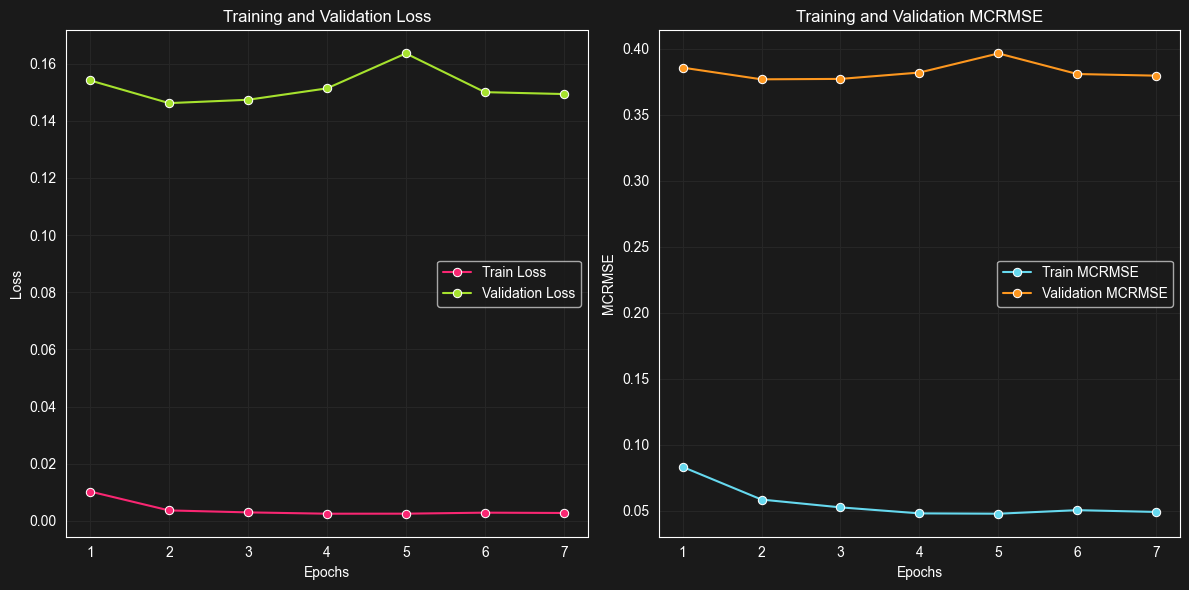

In [17]:
# After training, call the function to plot
plot_graphs(train_losses, val_losses, train_mcrmse, val_mcrmse)

## Saving torch script

In [18]:
model.load_state_dict(torch.load('./out/best_model.pt'))

<All keys matched successfully>

In [19]:
exemple_batches = dataset.get_batch('train')
ex_batch = next(exemple_batches)
prompt_question = ex_batch['prompt_question']
prompt_text = ex_batch['prompt_text']
text = ex_batch['text']
example_input_tensor = torch.cat((prompt_question, prompt_text, text), dim=1)

In [20]:
# Trace the model
traced_model = torch.jit.trace(model.to('cpu'), example_input_tensor.to('cpu'))
# Save the traced model
traced_model.save("./out/best_model_script.pt")

## Load the Traced Model

In [21]:
loaded_model = torch.jit.load("./out/best_model_script.pt").to(device)

In [22]:
loaded_model(example_input_tensor.to(device))

tensor([[-0.2974, -0.3928],
        [-0.2182, -0.1461],
        [-0.3617, -0.5341],
        [-0.0850, -0.3860],
        [-0.1660, -0.2751],
        [-0.2886, -0.3470],
        [-0.3674, -0.3947],
        [-0.0973, -0.2352],
        [-0.0388, -0.1762],
        [-0.2521, -0.0943],
        [-0.0879, -0.2638],
        [-0.0586, -0.2261]], device='cuda:0', grad_fn=<TanhBackward0>)